
====== ÇALIŞTIRMA 1/10 BAŞLADI ======

--- Özet ---
                  Yöntem    x1(h)    x2(l)    x3(t)    x4(b)  En iyi maliyet          tau        sigma          Pc    delta      b-h  Sure (s)
   Jaya + Arnold (Ykş.2) 0.525864 6.202324 3.043254 1.869265        7.423729 13599.806771 29112.751802 6001.915110 0.250000 1.343401  0.476177
Jaya + Bernoulli (Ykş.1) 0.519077 6.289246 3.043280 1.869284        7.424903 13595.819578 29111.955670 6002.144226 0.249991 1.350207  0.379641
         Jaya (Orijinal) 0.516700 6.318338 3.043531 1.870388        7.428082 13597.669684 29089.964962 6013.236760 0.249781 1.353689  0.402981
Jaya + Chebyshev (Ykş.2) 0.531741 6.133799 3.043811 1.869760        7.428628 13588.874723 29094.408690 6007.672669 0.249797 1.338018  0.598788
    Jaya + Cubic (Ykş.2) 0.591705 5.425374 3.061456 1.868000        7.442936 13595.298153 28787.078873 6022.176302 0.245734 1.276295  0.489004
   Jaya + Arnold (Ykş.1) 0.797128 3.694180 3.057958 1.866770        7.452583 13599.361681

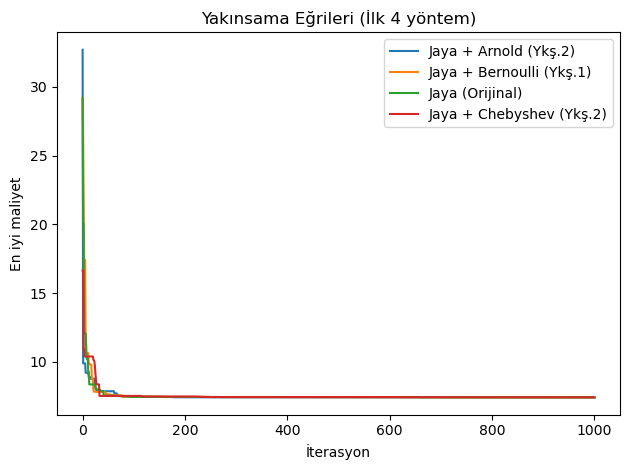

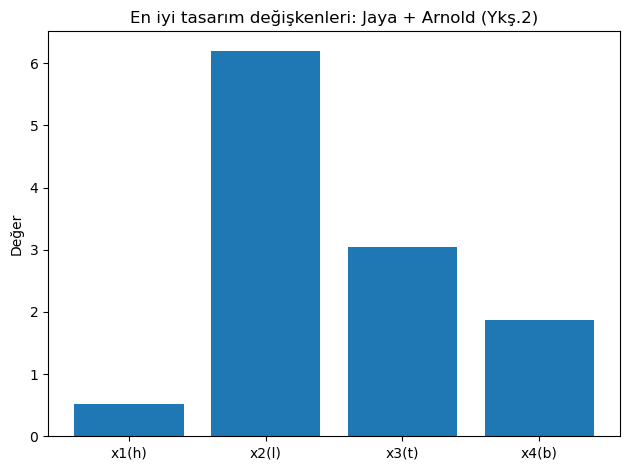

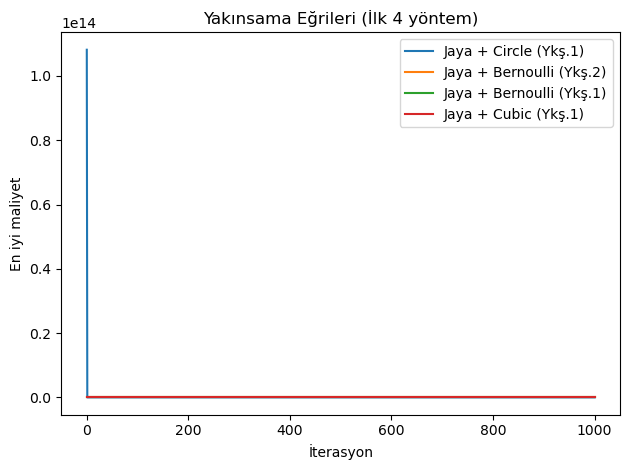

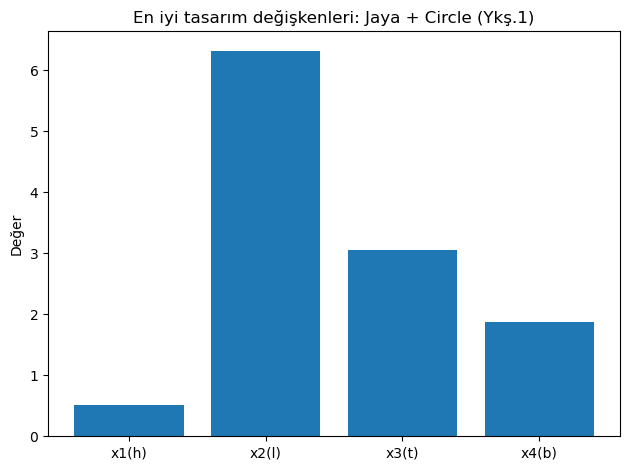

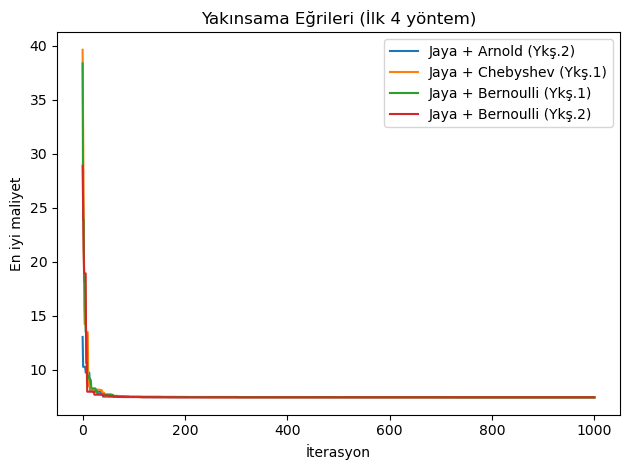

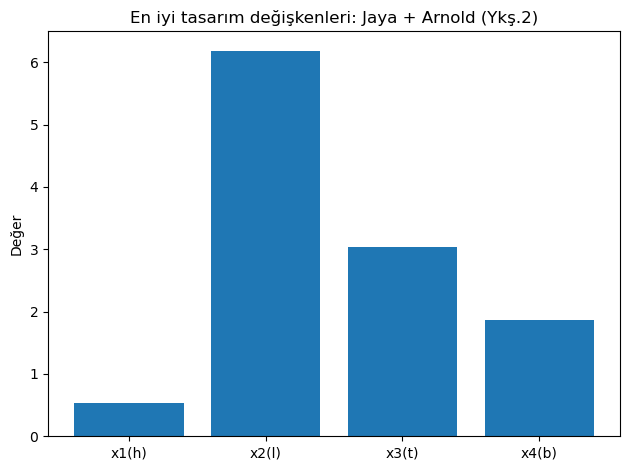

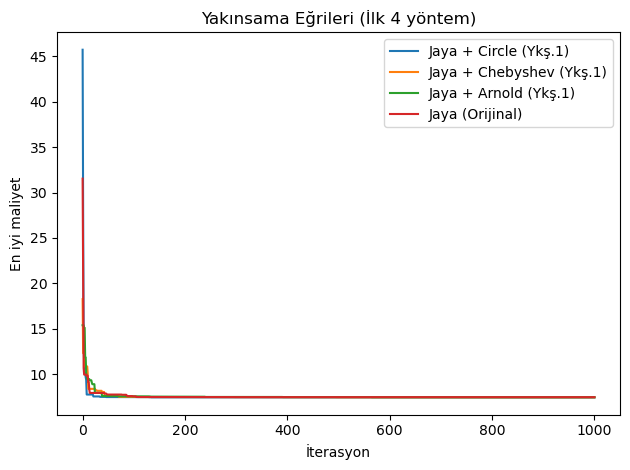

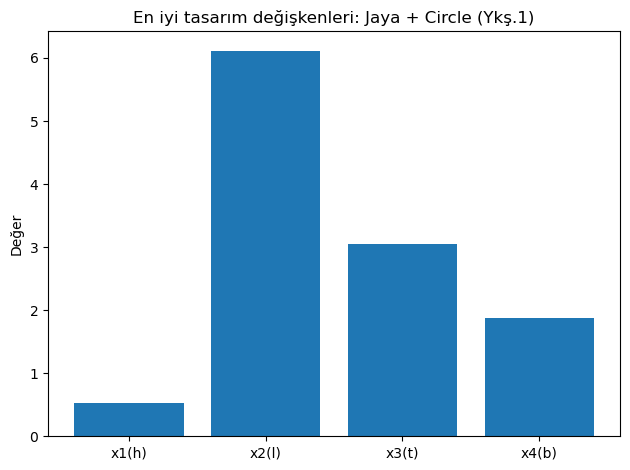

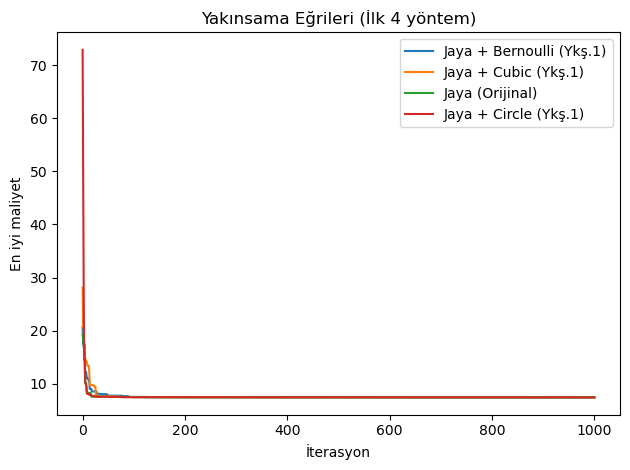

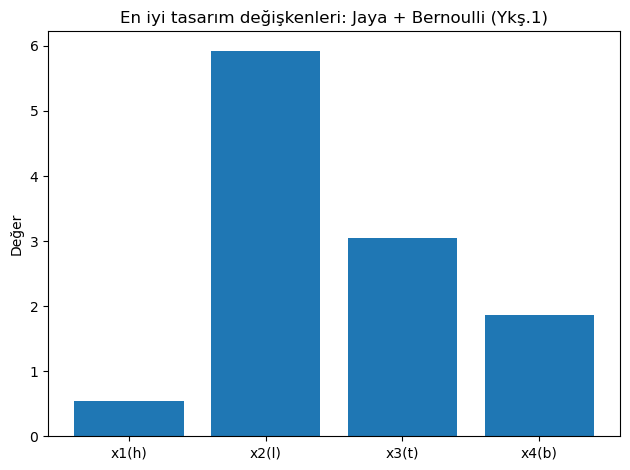

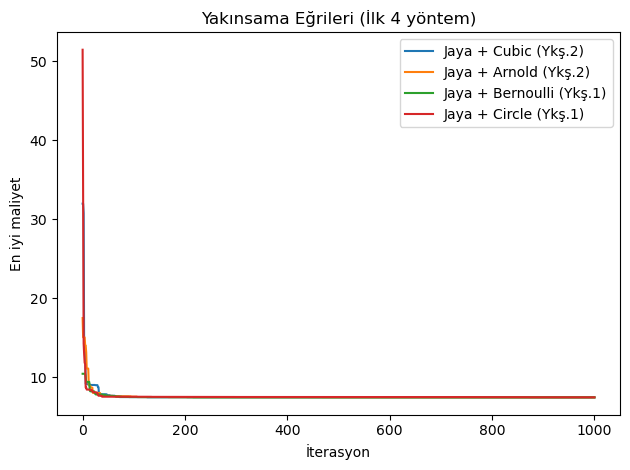

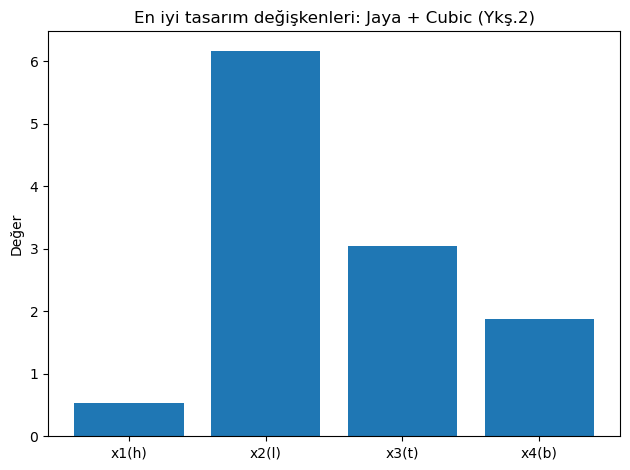

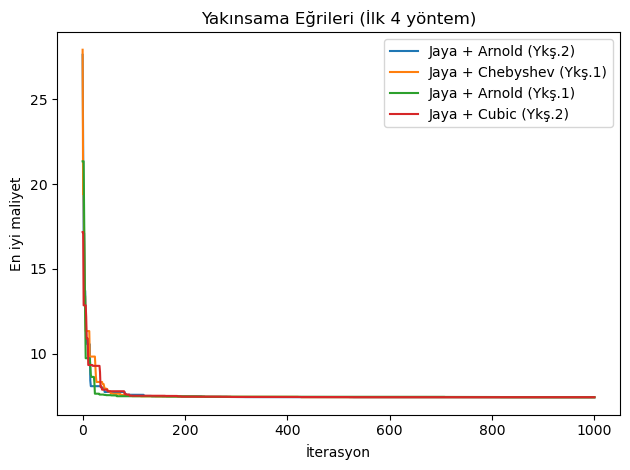

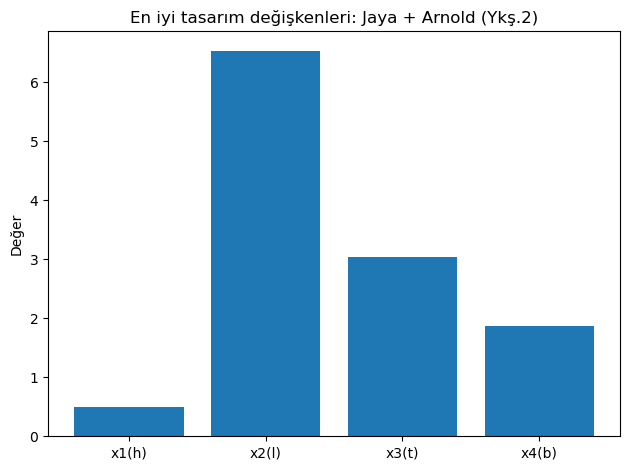

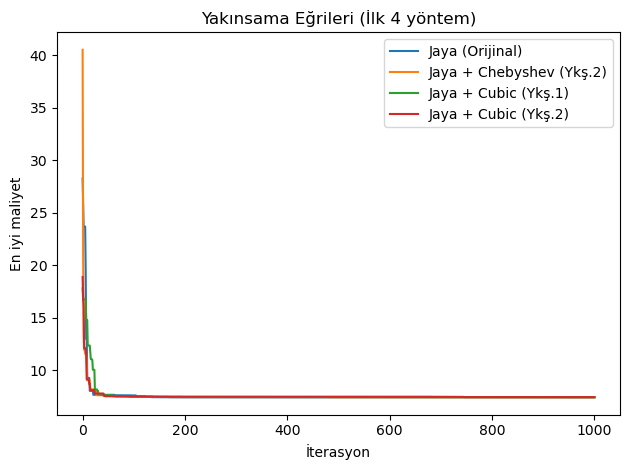

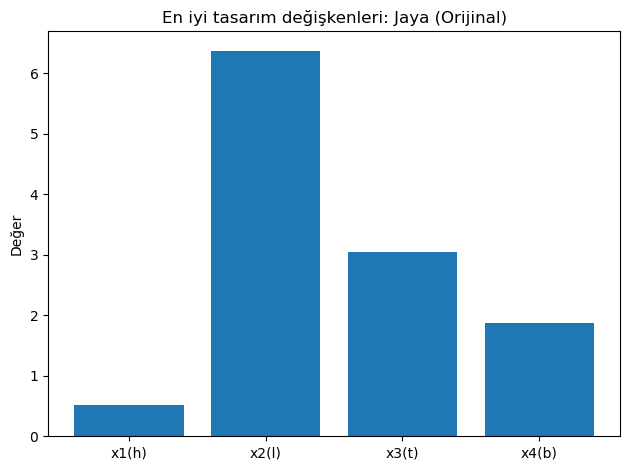

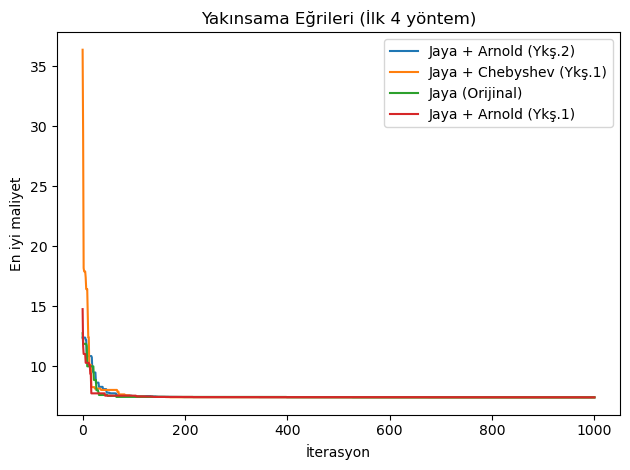

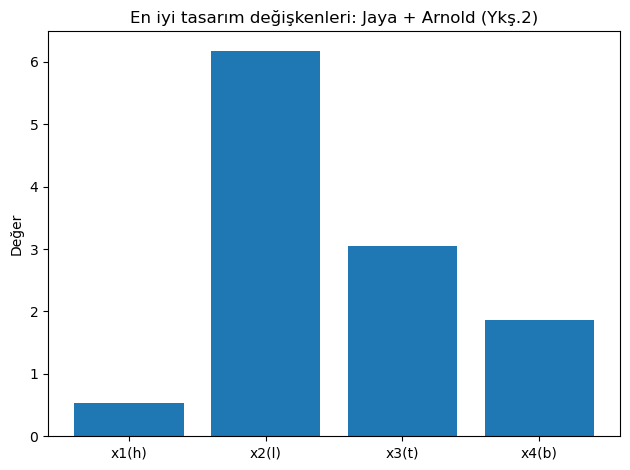

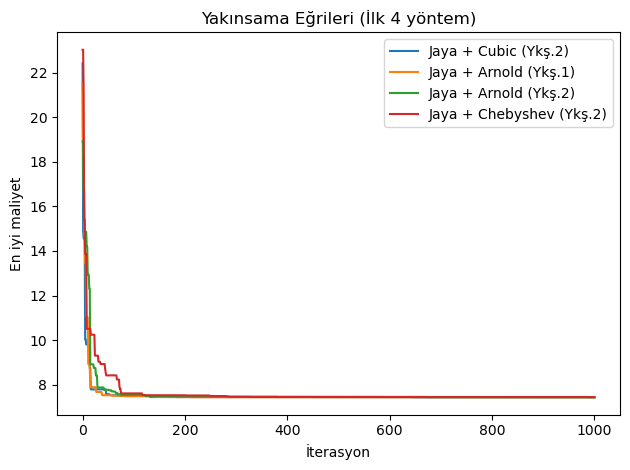

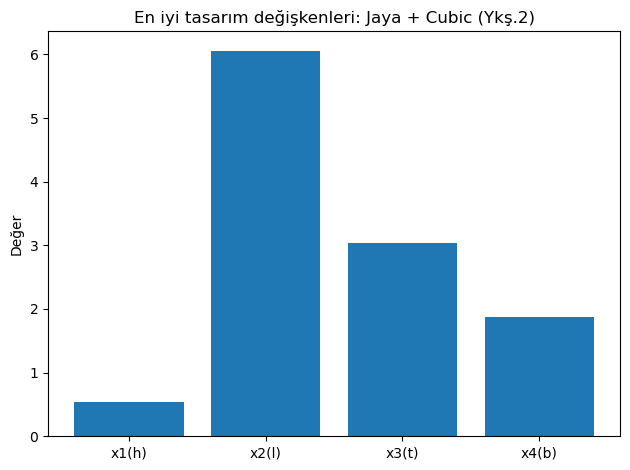

In [21]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

# ============================================================
#   Welded Beam Problemi 

#  ---- ITERATION COUNT ----
MAX_ITER = 1000   # <- 100 / 500 / 1000 vb. 



P = 6000.0     # lb
L_fixed = 14.0 # in
E = 30e6       # psi
G = 12e6       # psi
tau_max = 13600.0 # psi
sigma_max = 30000.0 # psi
delta_max = 0.25    # in

# Değişkenler: x = [h, l, t, b]
lb = np.array([0.125, 0.1, 0.1, 0.125], dtype=float)
ub = np.array([5.0,   10.0, 10.0, 5.0], dtype=float)

def welded_beam_cost(x):
    h, l, t, b = x
    return 1.10471*h*h*l + 0.04811*t*b*(14.0 + l)

def welded_beam_constraints_raw(x):
    """tau, sigma, Pc, delta, b_minus_h döndürür."""
    h, l, t, b = x
    alpha = math.sqrt(0.25*(l*l + (h + t)*(h + t)))
    tau_prime = P / (math.sqrt(2.0) * h * l)
    J = 2.0 * (0.707*h*l) * ( (l*l)/12.0 + 0.25*(h + t)*(h + t) )
    tau_b = P*(L_fixed + 0.5*l)*alpha / J
    tau = math.sqrt(tau_prime*tau_prime + tau_b*tau_b + (l*tau_prime*tau_b)/alpha)
    sigma = 504000.0 / (t*t*b)
    delta = (65856.0*P)/(E*(t**3)*b)
    Pc = 64746.022*(1.0 - 0.0282346*t)*t*(b**3) / (L_fixed**2)
    b_minus_h = b - h
    return tau, sigma, Pc, delta, b_minus_h

def welded_beam_penalty(x):
    tau, sigma, Pc, delta, b_minus_h = welded_beam_constraints_raw(x)
    g = [
        tau - tau_max,          # <= 0
        sigma - sigma_max,      # <= 0
        delta - delta_max,      # <= 0
        6000.0 - Pc,            # <= 0 (Pc >= 6000)
        -(b_minus_h),           # <= 0 (b - h >= 0)
    ]
    viol = [max(0.0, gi) for gi in g]
    return sum(v*v for v in viol), g

def fitness(x, penalty_coef=1e8):
    c = welded_beam_cost(x)
    pen, _ = welded_beam_penalty(x)
    return c + penalty_coef*pen


def bernoulli_shift(x, lam=0.7):
    return x/lam if x < lam else (x - lam)/(1.0 - lam)

def chebyshev_map(x, f=4):
    y = 2.0*x - 1.0
    y_next = math.cos(f*math.acos(max(-1.0, min(1.0, y))))
    return (y_next + 1.0)/2.0

def circle_map(x, a=0.5, k=0.2):
    return (x + a - (k/(2.0*math.pi))*math.sin(2.0*math.pi*x)) % 1.0

def cubic_map(x, r=2.59):
    xn = r*x*(1.0 - x*x)
    if xn <= 0.0 or xn >= 1.0 or math.isnan(xn):
        xn = (abs(xn) % 1.0) or 0.5
    return xn

def arnold_cat_map(xy):
    x, y = xy
    return (x + y) % 1.0, (x + 2.0*y) % 1.0

def chaotic_sequence(length, method="bernoulli", seed=0.12345):
    seq = []
    if method == "arnold":
        x, y = ((seed*7.123) % 1.0, (seed*3.789) % 1.0)
        for _ in range(length):
            x, y = arnold_cat_map((x, y))
            seq.append(x); seq.append(y)
        seq = seq[:length]
    else:
        x = (seed*1.234567) % 1.0
        if x <= 0.0:
            x = 0.123456
        for _ in range(length):
            if method == "bernoulli":
                x = bernoulli_shift(x, lam=0.7)
            elif method == "chebyshev":
                x = chebyshev_map(x, f=4)
            elif method == "circle":
                x = circle_map(x, a=0.5, k=0.2)
            elif method == "cubic":
                x = cubic_map(x, r=2.59)
            else:
                # fallback LCG
                x = (x*9301 + 49297) % 233280 / 233280.0
            x = min(1.0 - 1e-12, max(1e-12, x))
            seq.append(x)
    return np.array(seq)


def jaya(pop_size=30, max_iter=500, approach="baseline", chaotic="none", seed=42):

    if seed is None:
        seed = np.random.randint(0, 1_000_000)

    
    rng = np.random.default_rng(seed)
    D = 4
    N = pop_size


    if approach == "chaos_init" and chaotic != "none":
        seq = chaotic_sequence(N*D, method=chaotic, seed=seed/100.0 + 0.13579)
        seq = seq.reshape(N, D)
        pop = lb + seq*(ub - lb)
    else:
        pop = lb + rng.uniform(size=(N, D))*(ub - lb)

    fit = np.array([fitness(ind) for ind in pop])
    best_idx = int(np.argmin(fit))
    best = pop[best_idx].copy()
    best_fit = fit[best_idx]
    history = [best_fit]

   
    if approach == "chaos_iter" and chaotic != "none":
        seq_len = max_iter*N*D*2
        cseq = chaotic_sequence(seq_len, method=chaotic, seed=seed/10.0 + 0.2468)
        cptr = 0
    else:
        cseq, cptr = None, 0

    for _ in range(max_iter):
        worst_idx = int(np.argmax(fit))
        worst = pop[worst_idx]
        new_pop = pop.copy()
        for i in range(N):
            r1 = rng.uniform(size=D)
            r2 = rng.uniform(size=D)
            if approach == "chaos_iter" and chaotic != "none":
                r1 = cseq[cptr:cptr+D]; cptr += D
                r2 = cseq[cptr:cptr+D]; cptr += D
            candidate = pop[i] + r1*(best - abs(pop[i])) - r2*(worst - abs(pop[i]))
            candidate = np.minimum(ub, np.maximum(lb, candidate))
            f_new = fitness(candidate)
            if f_new < fit[i]:
                new_pop[i] = candidate
                fit[i] = f_new
                if f_new < best_fit:
                    best_fit = f_new
                    best = candidate.copy()
        pop = new_pop
        history.append(best_fit)
    return best, best_fit, np.array(history)


def run_experiments():
    methods = [
        ("baseline", "none",       "Jaya (Orijinal)"),
        ("chaos_init", "arnold",   "Jaya + Arnold (Ykş.1)"),
        ("chaos_init", "bernoulli","Jaya + Bernoulli (Ykş.1)"),
        ("chaos_init", "chebyshev","Jaya + Chebyshev (Ykş.1)"),
        ("chaos_init", "circle",   "Jaya + Circle (Ykş.1)"),
        ("chaos_init", "cubic",    "Jaya + Cubic (Ykş.1)"),
        ("chaos_iter", "arnold",   "Jaya + Arnold (Ykş.2)"),
        ("chaos_iter", "bernoulli","Jaya + Bernoulli (Ykş.2)"),
        ("chaos_iter", "chebyshev","Jaya + Chebyshev (Ykş.2)"),
        ("chaos_iter", "circle",   "Jaya + Circle (Ykş.2)"),
        ("chaos_iter", "cubic",    "Jaya + Cubic (Ykş.2)"),
    ]

    results = []
    histories = {}

    for appr, cmap, label in methods:
        t0 = time.time()
        best, bestfit, hist = jaya(pop_size=20, max_iter=MAX_ITER, approach=appr, chaotic=cmap, seed=None)
        runtime = time.time() - t0
        tau, sigma, Pc, delta, bmh = welded_beam_constraints_raw(best)
        results.append({
            "Yöntem": label,
            "x1(h)": best[0],
            "x2(l)": best[1],
            "x3(t)": best[2],
            "x4(b)": best[3],
            "En iyi maliyet": bestfit,
            "tau": tau, "sigma": sigma, "Pc": Pc, "delta": delta, "b-h": bmh,
            "Sure (s)": runtime
        })
        histories[label] = hist

    df = pd.DataFrame(results).sort_values("En iyi maliyet").reset_index(drop=True)
    csv_path = "kaynakli_kiris_jaya_chaos_results_1000_10.csv"
    df.to_csv(csv_path, index=False)

   
    top_labels = list(df["Yöntem"].head(4).values)
    plt.figure()
    for lbl in top_labels:
        plt.plot(histories[lbl], label=lbl)
    plt.xlabel("İterasyon")
    plt.ylabel("En iyi maliyet")
    plt.title("Yakınsama Eğrileri (İlk 4 yöntem)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("yakin_sama_egri.png", dpi=160)

   
    best_label = df.iloc[0]["Yöntem"]
    bx = df.iloc[0][["x1(h)", "x2(l)", "x3(t)", "x4(b)"]].values
    plt.figure()
    plt.bar(["x1(h)","x2(l)","x3(t)","x4(b)"], bx)
    plt.ylabel("Değer")
    plt.title(f"En iyi tasarım değişkenleri: {best_label}")
    plt.tight_layout()
    plt.savefig("en_iyi_tasarim_deg.png", dpi=160)

    print("\n--- Özet ---")
    print(df.head(6).to_string(index=False))
    print("\nKaydedilen dosyalar:")
    print(" -", csv_path)
    print(" - yakin_sama_egri.png")
    print(" - en_iyi_tasarim_deg.png")
    return df

if __name__ == "__main__":
    # 10 kez art arda çalıştır
    for run_id in range(1, 11):
        print(f"\n====== ÇALIŞTIRMA {run_id}/10 BAŞLADI ======")
        df = run_experiments()

        # Dosya adını dinamik oluştur
        csv_path = f"kaynakli_kiris_jaya_chaos_results_1000_{run_id}.csv"
        df.to_csv(csv_path, index=False)

        print(f"Kaydedildi: {csv_path}")
        print(f"====== ÇALIŞTIRMA {run_id}/10 BİTTİ ======\n")

